# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.883800,True,6.032204
1,2.151652,True,8.274524
2,0.565327,True,5.615925
3,1.943763,True,9.943361
4,1.025108,True,6.526274
...,...,...,...
995,-1.452482,False,-1.081065
996,1.532964,False,2.817101
997,-0.350965,True,1.761346
998,-1.642007,False,-3.852874


<AxesSubplot:xlabel='v0'>

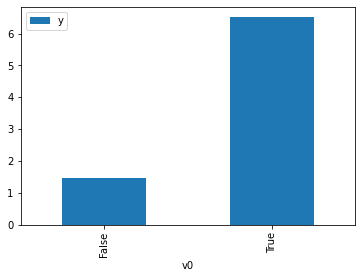

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

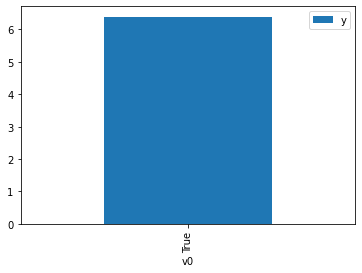

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.117996,False,2.497059,0.333225,3.000976
1,0.238462,False,0.509070,0.455258,2.196556
2,0.213945,False,2.279505,0.458815,2.179528
3,0.425245,False,-0.297296,0.428336,2.334615
4,2.301323,False,3.431520,0.200139,4.996525
...,...,...,...,...,...
995,0.621286,False,1.458936,0.400531,2.496683
996,1.642750,False,3.409962,0.268860,3.719407
997,0.409933,False,-0.635569,0.430529,2.322722
998,-0.063154,False,0.953209,0.499221,2.003123


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.055191,True,5.738184,0.658568,1.518446
1,1.676538,True,7.187013,0.735005,1.360535
2,0.111945,True,4.353155,0.526346,1.899889
3,-0.840229,True,3.503758,0.389082,2.570151
4,0.556640,True,5.125285,0.590361,1.693878
...,...,...,...,...,...
995,0.018338,True,6.145009,0.512687,1.950507
996,0.094625,True,5.329991,0.523821,1.909048
997,0.711712,True,4.394407,0.612092,1.633741
998,1.928415,True,8.157832,0.762678,1.311169


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                          1.620e+04
Date:                Tue, 02 Mar 2021   Prob (F-statistic):                        0.00
Time:                        20:29:26   Log-Likelihood:                         -1414.1
No. Observations:                1000   AIC:                                      2832.
Df Residuals:                     998   BIC:                                      2842.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7444      0.031     55.843      0.000       1.683       1.806
x2             5.0338      0.052     97.742      0.000       4.933       5.135
==============================================================================
Omnibus:                        4.501   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.538
Skew:                           0.147   Prob(JB):                        0.103
Kurtosis:                       2.851   Cond. No.                         2.50
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""